In [1]:
from lora.models.roberta_scratch import get_model

from lora.compress.gregodec import GreGoDec
from lora.compress.tsvd import TSVD

from omegaconf import OmegaConf
from transformers import RobertaTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import scipy as scp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class SelfAttention(nn.Module):
    def __init__(self, config, rank=1):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # self.B = torch.randn((config.hidden_size+1, config.hidden_size+1))

        self.U = torch.nn.Parameter(
            data=torch.randn((config.hidden_size+1, rank)),
            requires_grad=False
        )
        self.V = torch.nn.Parameter(
            data=torch.randn((rank, config.hidden_size+1)),
            requires_grad=False
        )
        self.S = torch.nn.Parameter(
            data=torch.randn((config.hidden_size+1, config.hidden_size+1)),
            requires_grad=False
        )

        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        value_layer = self.value(hidden_states)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        X = torch.cat((hidden_states, torch.ones_like(hidden_states)[:, :, :1]), axis=-1)
        M = torch.matmul(self.U, self.V) + self.S
        attention_scores = torch.matmul(
                torch.matmul(X, M),
                X.transpose(-1, -2)
            )

        # scale the attention scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask.view(attention_scores.shape[0], 1, attention_scores.shape[-1])

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs


In [21]:
def get_approx_matrix(W, target_rank, type, return_approx=False):
    if type == 'gregodec':
        if target_rank <= 10:
            k = 1
        elif target_rank <= 100:
            k = 10
        else: 
            k = 100
        U, V, S, _ = GreGoDec(
            D = W,
            rank = target_rank,
            tau = 0.001,
            tol = 0.001, 
            power = 100,
            k = k
        ).fit()
        if return_approx:
            return U @ V + S
        else:
            return U, V, S
    elif type == 'tsvd':
        U, V = TSVD(
            D=W,
            rank=target_rank
        ).fit()
        if return_approx:
            return U @ V
        else:
            return U, V, np.zeros_like(W)
    else:
        raise NotImplementedError

def get_approx_model(model, rank, type):
    approx_model = deepcopy(model)
    if rank == 769:
        return approx_model
    else:
        for i in range(model.roberta_encoder.config.num_hidden_layers):
            old = approx_model.roberta_encoder.encoder.layer[i].attention.self

            # get the original B matrix
            Wq = torch.vstack([old.query.weight.transpose(0, 1), old.query.bias]).cpu()
            Wk = torch.vstack([old.key.weight.transpose(0, 1), old.key.bias]).cpu()
            B = (Wq @ Wk.T).cpu().detach().numpy()

            # approximate
            U, V, S = get_approx_matrix(B, target_rank=rank, type=type, return_approx=False)

            approx_model.roberta_encoder.encoder.layer[i].attention.self = SelfAttention(model.roberta_encoder.config)
            approx_model.roberta_encoder.encoder.layer[i].attention.self.U.data = torch.from_numpy(U).float()
            approx_model.roberta_encoder.encoder.layer[i].attention.self.V.data = torch.from_numpy(V).float()
            approx_model.roberta_encoder.encoder.layer[i].attention.self.S.data = torch.from_numpy(S).float()
            approx_model.roberta_encoder.encoder.layer[i].attention.self.value.weight = old.value.weight
            approx_model.roberta_encoder.encoder.layer[i].attention.self.value.bias = old.value.bias
        return approx_model

def evaluate(model, dataloader, device):
    model.eval()
    num_correct_preds = 0
    num_test_samples = 0
    progress = tqdm(enumerate(dataloader), total=len(dataloader))
    with torch.no_grad():
        for i, data in progress:
            ids = data["input_ids"].long().to(device)
            token_type_ids = data["token_type_ids"].long().to(device)
            masks = data["attention_mask"].long().to(device)
            targets = data["label"].long().to(device)
            batchsize = len(targets)

            outputs = model(ids, masks, token_type_ids)

            num_test_samples += batchsize
            num_correct_preds += (
                (torch.argmax(outputs, axis=1) == targets)
                .detach()
                .cpu()
                .numpy()
                .sum()
            )

            progress.set_description(f"[{i + 1}/{len(dataloader)}] ")
    return num_correct_preds / num_test_samples

In [9]:
# load original model
args = OmegaConf.load("../config.yaml")
weights_path = "../outputs/2024-04-25/08-40-45/scratch.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_model(args)
model.load_state_dict(torch.load(weights_path))

# prepare the validation dataset
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)


In [22]:
rank_list = [1, 5, 10, 100, 200, 300, 400, 500, 700, 769]
type_list = ['tsvd', 'gregodec']
acc_list = [[] for _ in range(len(type_list))]

for rank in rank_list:
    print(f"computing for rank: {rank}")
    for i, type in enumerate(type_list):
        approx_model = get_approx_model(model, rank=rank, type=type)
        approx_model.to(device)
        acc = evaluate(approx_model, dataloader, device)
        acc_list[i].append(acc)

computing for rank: 1


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.80it/s]


computing for rank: 5


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 25.02it/s]


computing for rank: 10


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 25.11it/s]


computing for rank: 100


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.62it/s]


computing for rank: 200


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.82it/s]


computing for rank: 300


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.88it/s]


computing for rank: 400


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.57it/s]


computing for rank: 500


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


computing for rank: 700


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 24.95it/s]


computing for rank: 769


[55/55] : 100%|██████████| 55/55 [00:02<00:00, 23.82it/s]


0
1


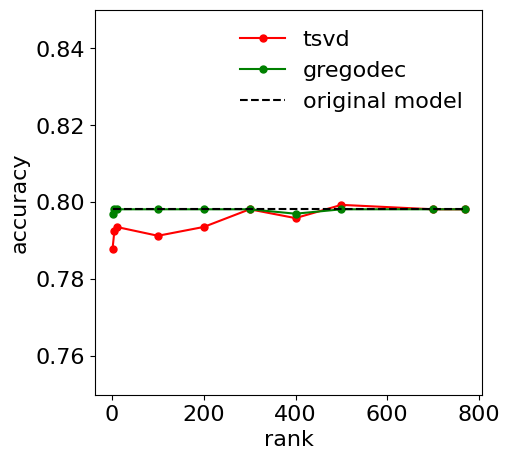

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
colors = ['r', 'g']

for i, type in enumerate(type_list):
    print(i)
    ax.plot(rank_list, acc_list[i], marker='o', ms=5, color=colors[i], label=type)

ax.plot(rank_list, acc_list[0][-1] * np.ones(len(rank_list)), ls='dashed', color='black', label='original model')

ax.set_xlabel("rank")
ax.set_ylabel("accuracy")
ax.legend(frameon=False)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_ylim([0.75, 0.85])
plt.show()

In [24]:
fig.savefig("rank-vs-acc.pdf", bbox_inches='tight')

In [ ]:
# get the sparse levels